In [49]:
import pandas as pd
from textblob import TextBlob
import glob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [50]:
dataset_names={0:"crisislex",1:"crisisnlp_crisismmd",2:"news_notNews",3:"Covid_WNUT", 4:"crisisnlp_Sandy_Japolin", 5:"crisisnlp_19Crisis", 6:"Karabakh"}

In [52]:
all_files = glob.glob("./dataset_cleaning/*.pkl")
all_files.sort()
datasets = []

for filename in all_files:
    print(filename)
    df = pd.read_pickle(filename)
    datasets.append(df)

./dataset_cleaning/dataset1Cleaned.pkl
./dataset_cleaning/dataset2Cleaned.pkl
./dataset_cleaning/dataset3Cleaned.pkl
./dataset_cleaning/dataset4Cleaned.pkl
./dataset_cleaning/dataset5Cleaned.pkl
./dataset_cleaning/dataset6Cleaned.pkl
./dataset_cleaning/dataset7Cleaned.pkl


In [53]:

def text_processing(tweet):
    
    tweet= tweet.lower()
    
    #Removing hyperlinks from the tweet
    tweet_no_links=re.sub(r'http\S+', '', tweet)
    
    #Generating the list of words in the tweet (hashtags and other punctuations removed)
    def form_sentence(tweet):
        tweet_blob = TextBlob(tweet)
        return ' '.join(tweet_blob.words)
    new_tweet = form_sentence(tweet_no_links)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(tweet):
        tweet_list = [ele for ele in tweet.split() if ele != 'user']
        clean_tokens = [t for t in tweet_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word not in stopwords.words('english')]
        return clean_mess
    no_punc_tweet = no_user_alpha(new_tweet)
    
    #Normalizing the words in tweets 
    def normalization(tweet_list):
        lem = WordNetLemmatizer()
        normalized_tweet = []
        for word in tweet_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_tweet.append(normalized_text)
        return " ".join(normalized_tweet)
    
    
    return normalization(no_punc_tweet)

In [72]:
for i,ds in enumerate(datasets):
    print("Processing dataset {}".format(i+1))
    ds['text_processed']=ds['text'].apply(text_processing)

Processing dataset 1
Processing dataset 2
Processing dataset 3
Processing dataset 4
Processing dataset 5
Processing dataset 6
Processing dataset 7


In [73]:
df_merged = pd.concat(datasets)
df_merged = df_merged.sample(frac=1).reset_index(drop=True)

In [74]:
from sklearn.model_selection import train_test_split

train_df_merged, test_df_merged= train_test_split(df_merged, test_size=0.3, random_state=42)

In [75]:
train_df_merged.head()

,id,Informativeness,text,positive_score,negative_score,emotional_devergence_score,text_processed
43067,526475908056502273,0,"#security #Job in #Roseville, MN: MACY'S IS HI...",2,-1,0.3,security job roseville mn macy hire seasonal l...
11196,391379645636935680,1,Fire activity has intensified around the area ...,1,-1,0.2,fire activity intensify around area bell darga...
2457,331397649028763648,0,56 leaders and members of #Hefajat-e-Islam hav...,1,-1,0.2,leaders members arrest dhaka bangladesh
55849,451560106023325696,1,And the tsunami warning horns have begun! #Chi...,2,-1,0.3,tsunami warn horn begin chileearthquake chile ...
34437,503663777321975808,1,VIDEO: People Describing The Napa Earthquake: ...,1,-1,0.2,video people describe napa earthquake northern...


In [64]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [65]:
from keras.models import Sequential
from keras import layers
import keras

def create_keras_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights=[embedding_matrix], 
                               input_length=maxlen, 
                               trainable=False))

    model.add(layers.GlobalMaxPool1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC()])
    return model

In [66]:
results_bak =results

In [76]:
embedding_dim = 300

results=[]
for i,train_df in enumerate([train_df_merged]):

    print("Training on Dataset {}".format(i+1))
    row=[]
    
    sentences_train = train_df['text_processed'].values
    y_train = train_df['Informativeness'].values
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train)
    
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
    
    maxlen = len(max(X_train, key=len)) #length of the longest sentance

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    
    print("Creating embedding matrix")
    embedding_matrix = create_embedding_matrix('glove_data/glove.6B.300d.txt',tokenizer.word_index, embedding_dim)
    
    model=create_keras_model(vocab_size, embedding_dim, embedding_matrix, maxlen)
    
    
    for j,test_df in enumerate([test_df_merged]):

        print("Testing on Dataset {}".format(j+1))
        sentences_test = test_df['text_processed'].values
        y_test = test_df['Informativeness'].values
        
        X_test = tokenizer.texts_to_sequences(sentences_test)
        X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
        
        history = model.fit(X_train, y_train, epochs=30, verbose=0, validation_data=(X_test, y_test),batch_size=10)
        
        y_pred_prob = model.predict(X_test)
        
        row.append(roc_auc_score(y_test, y_pred_prob))
    results.append(row)
    
    

Training on Dataset 1
Creating embedding matrix
Testing on Dataset 1


In [85]:
train_df_merged

,id,Informativeness,text,positive_score,negative_score,emotional_devergence_score,text_processed
43067,526475908056502273,0,"#security #Job in #Roseville, MN: MACY'S IS HI...",2,-1,0.3,security job roseville mn macy hire seasonal l...
11196,391379645636935680,1,Fire activity has intensified around the area ...,1,-1,0.2,fire activity intensify around area bell darga...
2457,331397649028763648,0,56 leaders and members of #Hefajat-e-Islam hav...,1,-1,0.2,leaders members arrest dhaka bangladesh
55849,451560106023325696,1,And the tsunami warning horns have begun! #Chi...,2,-1,0.3,tsunami warn horn begin chileearthquake chile ...
34437,503663777321975808,1,VIDEO: People Describing The Napa Earthquake: ...,1,-1,0.2,video people describe napa earthquake northern...
...,...,...,...,...,...,...,...
62570,243417254748893184,1,"#worldnews Powerful quake hits Costa Rica, two...",1,-3,0.4,worldnews powerful quake hit costa rica two de...
38158,468554005610639360,1,RT @OutFrontCNN: First U.S. transmission of ki...,1,-2,0.3,rt outfrontcnn first transmission killer virus...
860,348488701770354688,1,"As Calgary copes w/ record flooding, studies p...",1,-2,0.3,calgary cop w record flood study point increas...
15795,384946800278257664,0,RT @GEMwrld: Can you guess what is this? It is...,1,-1,0.2,rt gemwrld guess puma amp sign andy warhol ear...


In [82]:
y_pred =(y_pred_prob > 0.5).astype("int32")
f1_score(y_test, y_pred)

0.8714062228402571

In [78]:
results

[[0.860417456984544]]

In [83]:
df = pd.DataFrame(results_bak[:-1])
df.columns= map( lambda x: x,df.columns)
df.index= map( lambda x: x,df.index)
df = df.iloc[:,:-1]
df.columns= map( lambda x: dataset_names[x],df.columns)
df.index= map( lambda x: dataset_names[x],df.index)

Text(0.5, 1.0, 'Glove')

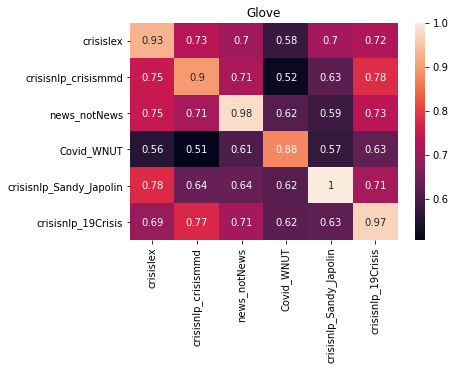

In [84]:
import matplotlib.pyplot as plt
sns.heatmap(df, annot=True,  vmax=1)
plt.title("Glove")

In [87]:
results_bak

[[0.9277134891976089,
  0.7291451263291326,
  0.700152638046233,
  0.5792738065711269,
  0.7048463243087002,
  0.7216943468540402,
  0.6519293655984302],
 [0.7505459623237039,
  0.898934242959338,
  0.7123557961315238,
  0.5211162046583064,
  0.6251019687188875,
  0.7803978422035752,
  0.5487246566383257],
 [0.7478469207706381,
  0.7090973649372121,
  0.9822484557911945,
  0.6174548055834933,
  0.5853389857725535,
  0.7319720076846394,
  0.5858731196860694],
 [0.5596641347418482,
  0.5056996667249245,
  0.6074030823834027,
  0.8777337836680357,
  0.5736615602016892,
  0.6311348634863486,
  0.6328319162851536],
 [0.7779083631851252,
  0.6376187907679389,
  0.6376108100102034,
  0.6164757565123884,
  0.999926132896554,
  0.709124190644871,
  0.6083714846304775],
 [0.6931026287984292,
  0.7746000498205056,
  0.7072911752443853,
  0.6224253329481686,
  0.6284773741850531,
  0.970610040842794,
  0.5734466971877042],
 [0.6105016194872477,
  0.5652707181987476,
  0.6745693083699957,
  0.59763